# Eshan Shakrani - 112802596

### Import Libraries

In [11]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image 
from scipy import ndimage 

### Load Data

In [12]:
train_data = h5py.File('data/train_catvnoncat.h5')
test_data =  h5py.File('data/test_catvnoncat.h5') 

print('Keys to access portions of the training data:')
print(train_data.keys())
print()

print(train_data['train_set_x'])
print(train_data['train_set_y'])
print(train_data['list_classes'])

print()
print()
print('Keys to access portions of the testing data:')
print(test_data.keys())
print()

print(test_data['test_set_x'])
print(test_data['test_set_y'])
print(test_data['list_classes'])

Keys to access portions of the training data:
<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

<HDF5 dataset "train_set_x": shape (209, 64, 64, 3), type "|u1">
<HDF5 dataset "train_set_y": shape (209,), type "<i8">
<HDF5 dataset "list_classes": shape (2,), type "|S7">


Keys to access portions of the testing data:
<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>

<HDF5 dataset "test_set_x": shape (50, 64, 64, 3), type "|u1">
<HDF5 dataset "test_set_y": shape (50,), type "<i8">
<HDF5 dataset "list_classes": shape (2,), type "|S7">


In [13]:
print('Possible labels for each sample:')
for label in train_data['list_classes']:
    print('\t-', label)

Possible labels for each sample:
	- b'non-cat'
	- b'cat'


##### Training data:  
Input - 209 samples of size (64, 64, 3) \
    -> each sample is an image with height = width = 64 pixels; 3 color channels (RGB) \
    \
Output - vector of size (209, 1): a label for each of the samples \
    -> possible labels: 'non-cat' or 'cat'

##### Testing data:
Input - 50 samples of size (64, 64, 3) \
Output - vector of size (50, 1): label for each of the samples

### Separate Data into Features and Labels

In [14]:
# break up training data
X_train = train_data['train_set_x'][:]
Y_train = train_data['train_set_y'][:]

# break up testing data
X_test = test_data['test_set_x'][:]
Y_test = test_data['test_set_y'][:]

# extract the list of possible labels
labels = train_data['list_classes'][:]

### Visualize Images 

##### Images in Training set:

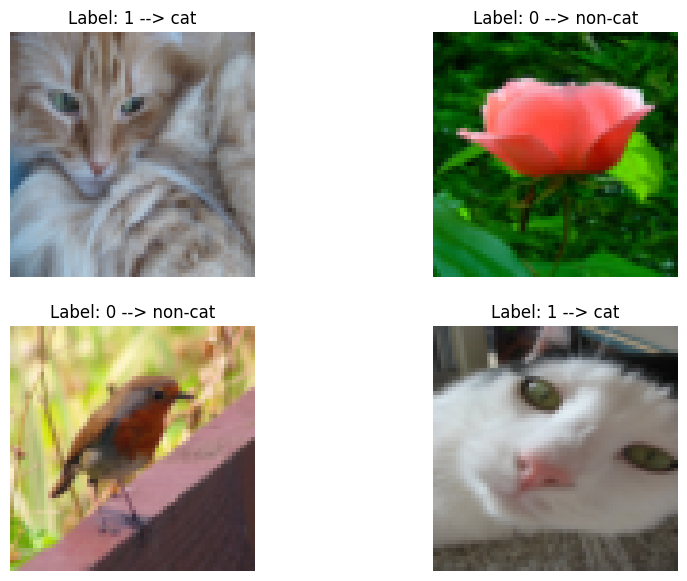

In [15]:
# pick 4 indices for images to show from the training set
indices = [2, 3, 10, 14]

# create figure
fig = plt.figure(figsize = (10, 7))

# define # of rows / columns
rows = 2
cols = 2

subplot_index = 1
for ind in indices:
    fig.add_subplot(rows, cols, subplot_index)
    subplot_index += 1
    plt.imshow(X_train[ind])
    plt.axis('off')

    # craft the title string for each picture 
    label_int = Y_train[ind]
    label_str = labels[label_int].decode('utf-8')
    title = f'Label: {label_int} --> {label_str}'
    plt.title(title)

##### Images in Testing set:

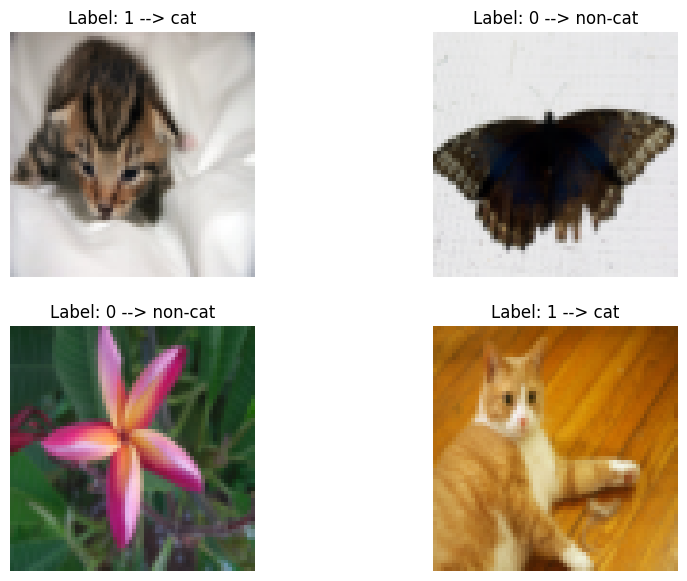

In [16]:
# pick 4 indices for images to show from the testing set
indices = [1, 13, 16, 19]

# create figure
fig = plt.figure(figsize = (10, 7))

# define # of rows / columns
rows = 2
cols = 2

subplot_index = 1
for ind in indices:
    fig.add_subplot(rows, cols, subplot_index)
    subplot_index += 1
    plt.imshow(X_test[ind])
    plt.axis('off')

    # craft the title string for each picture 
    label_int = Y_test[ind]
    label_str = labels[label_int].decode('utf-8')
    title = f'Label: {label_int} --> {label_str}'
    plt.title(title)

### Flatten and Normalize the Data

In [17]:
# for each sample, convert the (64, 64, 3) size data into a 
# vector of size 12288 (= 64 * 64 * 3) 
# then normalize the data by dividing by 255 

# X_train data: original shape (209, 64, 64, 3) -> new shape (209, 12288)
X_train_flat = X_train.reshape((X_train.shape[0], np.prod(X_train.shape[1:4])))
X_train_flat = X_train_flat / 255

# X_test data: original shape (50, 64, 64, 3) -> new shape (50, 12288)
X_test_flat = X_test.reshape((X_test.shape[0], np.prod(X_train.shape[1:4])))
X_test_flat = X_test_flat / 255

# Y_train data: original shape (209, ) -> new shape (209, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)

# Y_test data: original shape (50, ) -> new shape (50, 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

### Helper Functions

In [18]:
# return a probability value [0, 1] for a given input z
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

$$ 
A = \sigma(Xw + b)
$$

In [19]:
def propagate(w, b, X, Y):
    '''
    Implement the cost function and its gradient 

    Arguments:
    w: weights - numpy array of size (num_px * num_px * 3, 1)
    b: bias - scalar
    X: data of size (num. samples, num_px * num_px * 3)
    Y: true "label" vector (0 - non-cat, 1 - cat) of size (num_samples, 1)

    Return:
    dw: gradient of loss function w.r.t. w - same shape as w
    db: gradient of loss function w.r.t. b - same shape as b
    cost: negative log-likelihood cost for logistic regression
    '''
    m = X.shape[0]
    
    # Forward propagation (X -> cost)
    A = sigmoid(np.dot(X, w) + b)
    
    cost = np.sum(((-1 * np.log(A)) * Y + (-1 * np.log(1 - A)) * (1 - Y))) / m 

    # Backward propagation (to find gradient)
    dw = (np.dot(X.T, (A-Y))) / m 
    db = (np.sum(A-Y)) / m 
    
    cost = np.squeeze(cost) 

    return dw, db, cost 

### Training

In [20]:
X = X_train_flat 
Y = Y_train 

# num. dims (cols) for each sample
dim = X_train_flat.shape[1] 

# initialize weights vector
w = np.zeros((dim, 1))

# initialize bias term
b = 0

# hyperparameters
num_iterations = 10000
learning_rate = 0.006
record_cost = 50 # print cost every 50 iterations
costs = [] 

for i in range(num_iterations):
    dw, db, cost = propagate(w, b, X, Y)

    # gradient descent
    w = w - (learning_rate * dw)
    b = b - (learning_rate * db)

    # record the costs
    if i % record_cost == 0:
        costs.append(cost)
        print(f'Iteration {i}: \tCost: {cost}')

scipy.io.savemat('Py_Project_2_Data/ibc1_weights.mat', {'weights': w})
scipy.io.savemat('Py_Project_2_Data/ibc1_biases.mat', {'biases': b})

Iteration 0: 	Cost: 0.6931471805599453
Iteration 50: 	Cost: 0.7281013187730963
Iteration 100: 	Cost: 0.6498112732446274
Iteration 150: 	Cost: 0.5919060823227436
Iteration 200: 	Cost: 0.5383118237783536
Iteration 250: 	Cost: 0.4875820528641594
Iteration 300: 	Cost: 0.4392616947889748
Iteration 350: 	Cost: 0.39323764869274214
Iteration 400: 	Cost: 0.34982476543067453
Iteration 450: 	Cost: 0.31024837330927285
Iteration 500: 	Cost: 0.2784984357971258
Iteration 550: 	Cost: 0.2606010237733836
Iteration 600: 	Cost: 0.2497640022987191
Iteration 650: 	Cost: 0.240093693258189
Iteration 700: 	Cost: 0.2311776728392282
Iteration 750: 	Cost: 0.2229155289076536
Iteration 800: 	Cost: 0.21522905139235488
Iteration 850: 	Cost: 0.20805455724093086
Iteration 900: 	Cost: 0.20133887003959522
Iteration 950: 	Cost: 0.19503682036924946
Iteration 1000: 	Cost: 0.18910956153096206
Iteration 1050: 	Cost: 0.18352336452191587
Iteration 1100: 	Cost: 0.17824871723940586
Iteration 1150: 	Cost: 0.17325962930914146
Itera

### Results

In [21]:
# load the results from the training process
w = scipy.io.loadmat('Py_Project_2_Data/ibc1_weights.mat')['weights']
b = scipy.io.loadmat('Py_Project_2_Data/ibc1_biases.mat')['biases']

# calculate probabilities for testing data 
A = sigmoid(np.dot(X_test_flat, w) + b)

# assign labels to the samples using their probabilities
Y_test_pred = (A >= 0.5) * 1.0

Y_train_pred = sigmoid(np.dot(X, w) + b)

print(f'Training accuracy: {(100 - np.mean(np.abs(Y_train_pred - Y_train)) * 100):2f}')

print(f'Testing accuracy: {(100 - np.mean(np.abs(Y_test_pred - Y_test)) * 100):2f}')

Training accuracy: 97.404120
Testing accuracy: 70.000000


### Report the Indices of Incorrect Test Predictions

In [22]:
# check that only the same two labels exist in the true and predicted data
np.unique(Y_test_pred).shape == np.unique(Y_test).shape and all(np.unique(Y_test_pred) == np.unique(Y_test))

True

In [23]:
# combine the true and predicted data into a single array 
combined = np.concatenate((Y_test, Y_test_pred), axis = 1)
combined.shape

(50, 2)

In [24]:
# extract the indices from the combined array where the columns don't match
diff_indices = np.where(((combined[:, 0] != combined[:, 1])))

In [25]:
print('Indices where the model predicted incorrectly:')
print(", ".join([str(n) for n in diff_indices[0]]))

Indices where the model predicted incorrectly:
6, 10, 11, 13, 18, 19, 24, 28, 29, 30, 34, 41, 44, 45, 46


#### Images that were Incorrectly Labeled

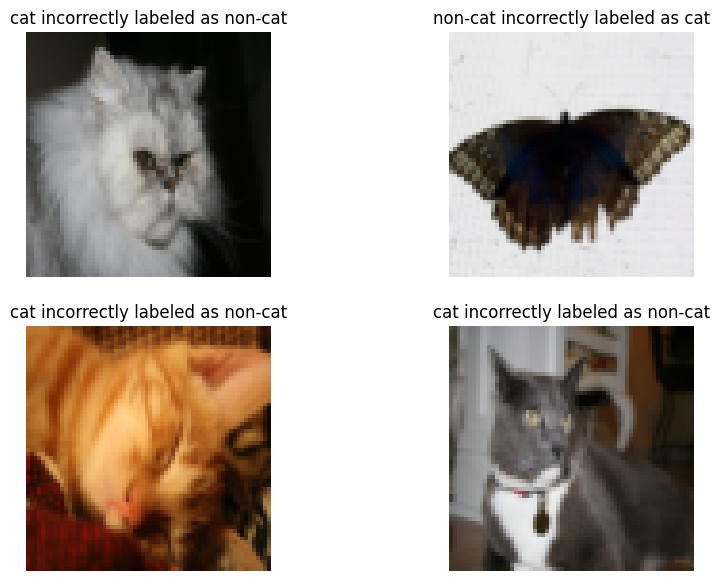

In [26]:
# pick 4 indices to show from the incorrect predictions
indices = [10, 13, 18, 24]

# create figure
fig = plt.figure(figsize = (10, 7))

# define # of rows / columns
rows = 2
cols = 2

subplot_index = 1
for ind in indices:
    fig.add_subplot(rows, cols, subplot_index)
    subplot_index += 1
    plt.imshow(X_test[ind])
    plt.axis('off')

    # craft the title string for each picture 
    label_true_int = int(Y_test[ind][0])
    label_pred_int = int(Y_test_pred[ind][0])
    label_true_str = labels[label_true_int].decode('utf-8')
    label_pred_str = labels[label_pred_int].decode('utf-8')
    title = f'{label_true_str} incorrectly labeled as {label_pred_str}'
    plt.title(title)